In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import json
import matplotlib.image as mpimg

import seaborn as sb
import torch
from torch import nn
from torch import optim

from torchvision import datasets, transforms, models
from collections import OrderedDict

import h5py

from PIL import Image



In [2]:
train_dir = 'E:\\AI\\MLND_CN_P7_DogvsCat\\train2'
test_dir = 'E:\\AI\\MLND_CN_P7_DogvsCat\\test2'

In [3]:
#导入特征
X_train = []
X_test = []

for filename in ["gap_Res.h5", "gap_Den.h5", "gap_VGG.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['train_label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)
inputs_features = X_train.shape[1]

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
Tr_sets = torch.utils.data.TensorDataset(X_train, y_train)
Tr_loader = torch.utils.data.DataLoader(Tr_sets, batch_size=128, shuffle=True)

X_test = torch.from_numpy(X_test).float()
Te_sets = torch.utils.data.TensorDataset(X_test)
Te_loader = torch.utils.data.DataLoader(Te_sets, batch_size=128)

In [4]:
#定义简单分类器模型
classifier = nn.Sequential(OrderedDict([('drop', nn.Dropout(p=0.5)),
                                        ('fc', nn.Linear(inputs_features, 1)),
                                        ('sigmoid', nn.Sigmoid())]))
cost = nn.BCELoss()
optimizer = optim.Adadelta(classifier.parameters(),lr=0.1)
# scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.99)
classifier.float().cuda()
for p in classifier.parameters():
    print(p.dtype)

torch.float32
torch.float32


In [5]:
#定义训练函数并训练
accuracy = {}
loss_dict = {}
val_dict = {}
def train(model, loader):
    since = time.time()
    steps = 0
    print_every = 40
    model.train()
    running_loss = 0
    for inputs, labels in loader:
        model.train()
        steps += 1
        optimizer.zero_grad()
        
        inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model.forward(inputs)
        loss = cost(outputs, labels[:,None])
        loss.backward()
        optimizer.step()
#         scheduler.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            
            with torch.no_grad():
                model.eval()
                test_loss = 0

                output = model.forward(inputs)
                test_loss += cost(output, labels[:,None]).item()
                
                output_01 = np.array([])
                for i in output:
                    if i >= 0.5:
                        output_01 = np.append(output_01, 1.)
                    elif i < 0.5:
                        output_01 = np.append(output_01, 0.)
                output_01 = torch.tensor(output_01)
                output_01 = output_01.float().cuda()
                equality = (labels.data == output_01)
                accuracy[str(e + 1) + '.' + str(steps)] = equality.type(torch.FloatTensor).mean().numpy()
                loss_dict[str(e + 1) + '.' + str(steps)] = running_loss/print_every
                val_dict[str(e + 1) + '.' + str(steps)] = test_loss
                print("Epoch: {}/{}.. ".format(e+1, epoch),
                      "Training Loss: {:.3f}.. ".format(loss_dict[str(e + 1) + '.' + str(steps)]),
                      "Valid Loss: {:.3f}.. ".format(val_dict[str(e + 1) + '.' + str(steps)]),
                      "Train Accuracy: {:.3f}".format(accuracy[str(e + 1) + '.' + str(steps)]))
                running_loss = 0

                model.train()
    since = time.time() - since
    
    print('Use', since)

In [6]:
epoch = 8 
for e in range(0, epoch):
    train(classifier, Tr_loader)
# torch.save(classifier, 'mixed{}.pth'.format(time.time()))

Epoch: 1/8..  Training Loss: 0.372..  Valid Loss: 0.197..  Train Accuracy: 0.992
Epoch: 1/8..  Training Loss: 0.158..  Valid Loss: 0.109..  Train Accuracy: 0.992
Epoch: 1/8..  Training Loss: 0.097..  Valid Loss: 0.115..  Train Accuracy: 0.977
Epoch: 1/8..  Training Loss: 0.071..  Valid Loss: 0.073..  Train Accuracy: 0.953
Use 2.522921562194824
Epoch: 2/8..  Training Loss: 0.050..  Valid Loss: 0.054..  Train Accuracy: 0.977
Epoch: 2/8..  Training Loss: 0.047..  Valid Loss: 0.053..  Train Accuracy: 0.969
Epoch: 2/8..  Training Loss: 0.050..  Valid Loss: 0.051..  Train Accuracy: 0.977
Epoch: 2/8..  Training Loss: 0.043..  Valid Loss: 0.035..  Train Accuracy: 0.984
Use 1.3839671611785889
Epoch: 3/8..  Training Loss: 0.043..  Valid Loss: 0.029..  Train Accuracy: 0.984
Epoch: 3/8..  Training Loss: 0.036..  Valid Loss: 0.021..  Train Accuracy: 1.000
Epoch: 3/8..  Training Loss: 0.037..  Valid Loss: 0.025..  Train Accuracy: 0.992
Epoch: 3/8..  Training Loss: 0.033..  Valid Loss: 0.069..  Train

In [7]:
#获取测试集的输出并保存csv
def get_outputs(model, loader):
    path_list = []
    predicted_list_1 = []
    predicted_list_2 = []
    model.cuda()
    for data in loader:
        model.eval()
        with torch.no_grad():
            data = data[0].cuda()
            score = model(data)
            
            predicted = torch.squeeze(score)
            predicted = predicted.data.cpu().numpy().tolist()
            predicted_list_1 += predicted
            
    predicted_list_2 = np.array(predicted_list_1).clip(min=0.005, max=0.995).tolist()
    classes =  datasets.ImageFolder(test_dir).classes
    path_list = np.array(classes).astype(int)
    outputs = pd.DataFrame({'id':path_list, 'label':predicted_list_2}).sort_values('id')
    
    now = time.time()
    outputs.to_csv('submission_{}.csv'.format(now), index=False)#保存时不用index
    csv_read = pd.read_csv('submission_{}.csv'.format(now), index_col='id')#读取时用一下index，方面读取
    display(csv_read)
    return csv_read

In [8]:
csv_read = get_outputs(classifier, Te_loader)

label
id             
1      0.995000
2      0.995000
3      0.995000
4      0.995000
5      0.005000
6      0.005000
7      0.005000
8      0.005000
9      0.005000
10     0.005000
11     0.005000
12     0.995000
13     0.005000
14     0.072634
15     0.005000
16     0.005000
17     0.939948
18     0.995000
19     0.005000
20     0.005000
21     0.995000
22     0.005000
23     0.995000
24     0.995000
25     0.005000
26     0.995000
27     0.995000
28     0.005000
29     0.124907
30     0.995000
...         ...
12471  0.995000
12472  0.995000
12473  0.005000
12474  0.005000
12475  0.005000
12476  0.995000
12477  0.995000
12478  0.939317
12479  0.005000
12480  0.005000
12481  0.005000
12482  0.005000
12483  0.005000
12484  0.995000
12485  0.005000
12486  0.995000
12487  0.995000
12488  0.995000
12489  0.995000
12490  0.992194
12491  0.995000
12492  0.995000
12493  0.995000
12494  0.995000
12495  0.005000
12496  0.005000
12497  0.005000
12498  0.995000
12499  0.995000
12500  0.005000

[12500 rows x 1 columns]

In [9]:
#随机生成一些图片并显示，请调整seed数值看其他图片。
def random_t(seed):
    np.random.seed(seed)
    r_list = np.random.randint(1, 12501, 20)
    for a in r_list:
        if csv_read.loc[a][0] > 0.5:
            lena = mpimg.imread('test\\{}.jpg'.format(a))
            plt.figure()
            plt.title('{} is a dog.Output is {:.4f}.'.format(a, csv_read.loc[a][0]))
            plt.imshow(lena)
        if csv_read.loc[a][0] < 0.5:
            lena = mpimg.imread('test\\{}.jpg'.format(a))
            plt.figure()
            plt.title('{} is a cat.Output is {:.4f}.'.format(a, csv_read.loc[a][0]))
            plt.imshow(lena)

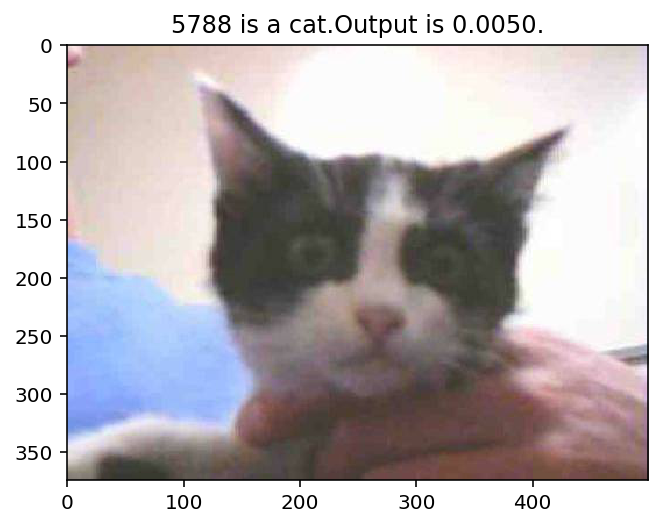

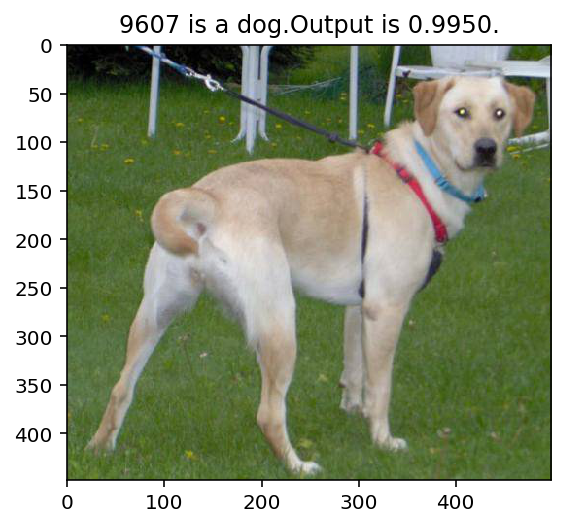

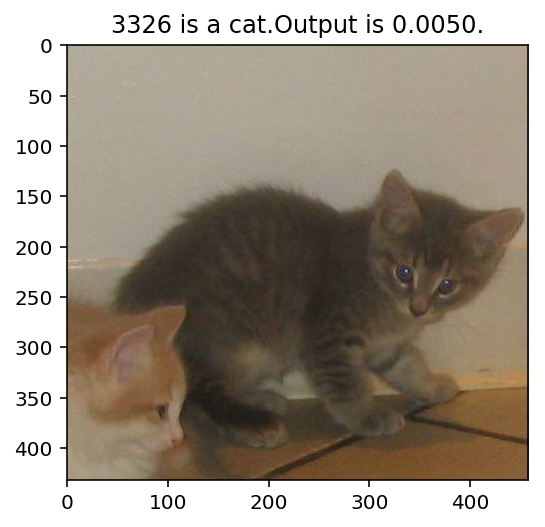

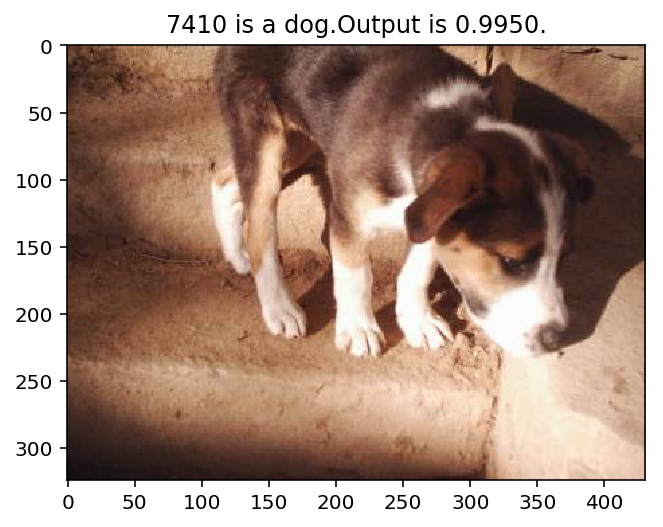

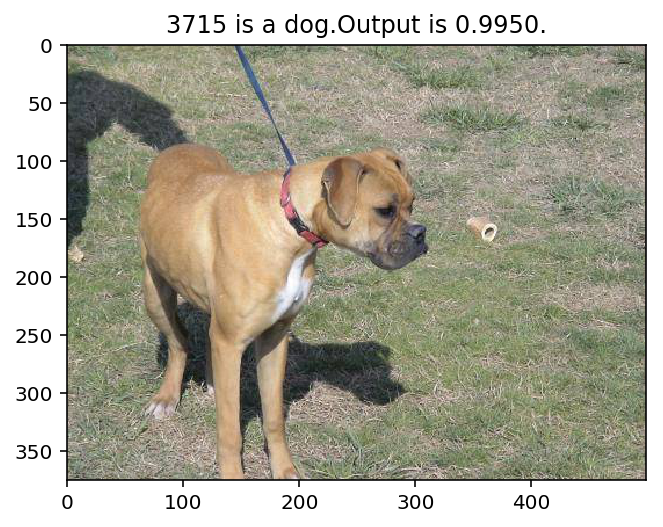

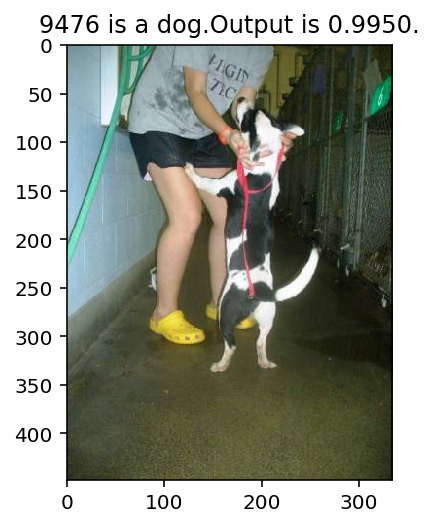

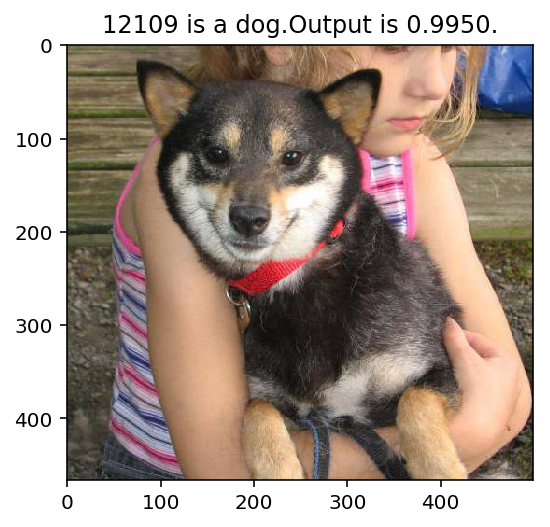

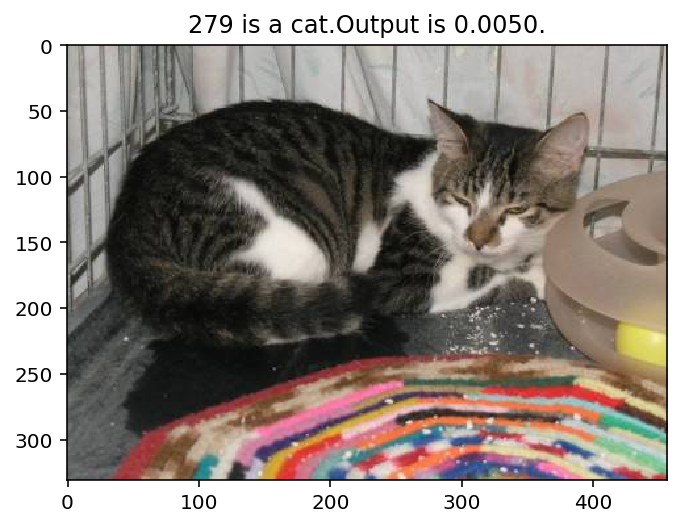

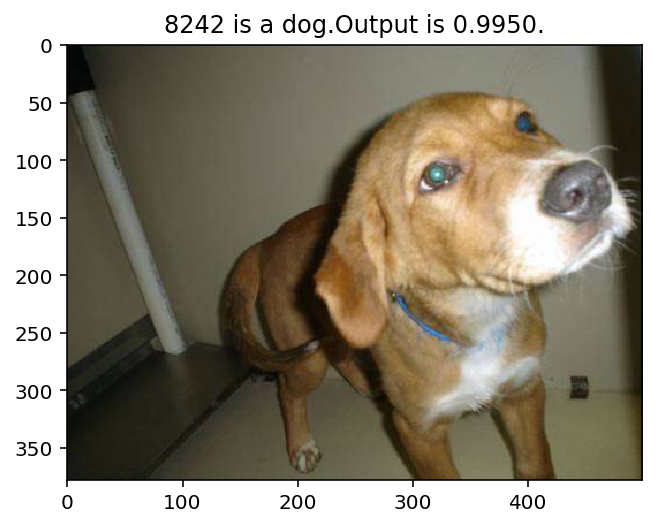

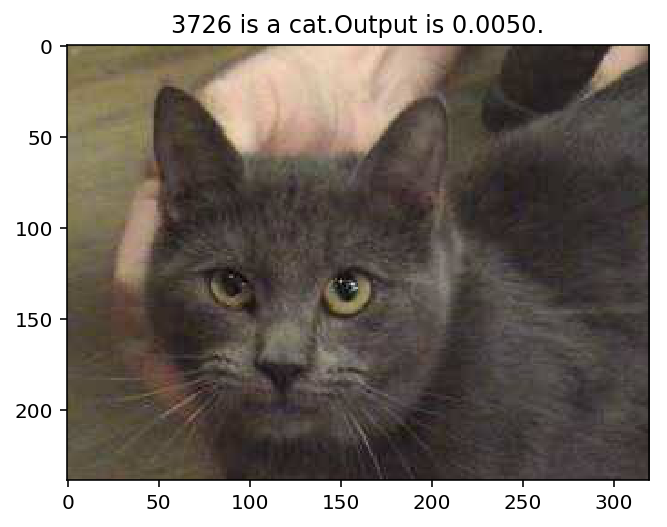

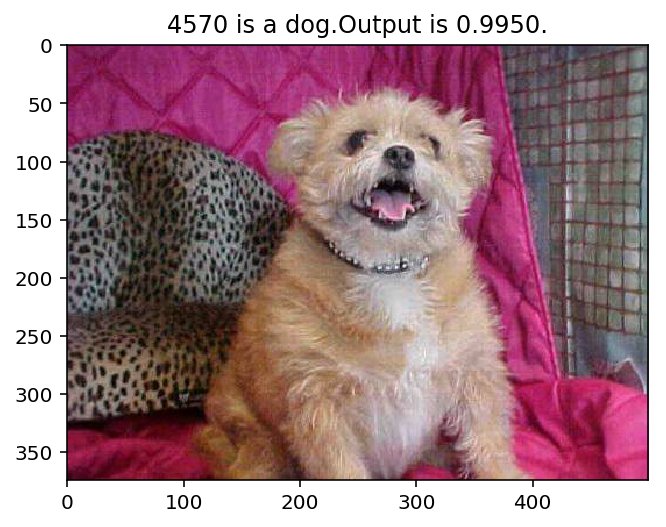

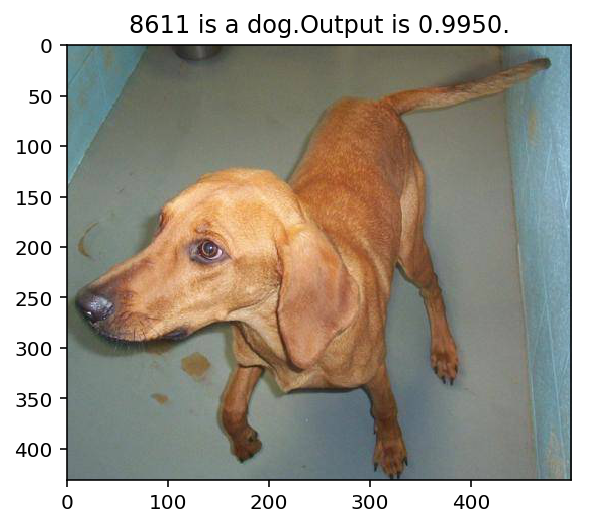

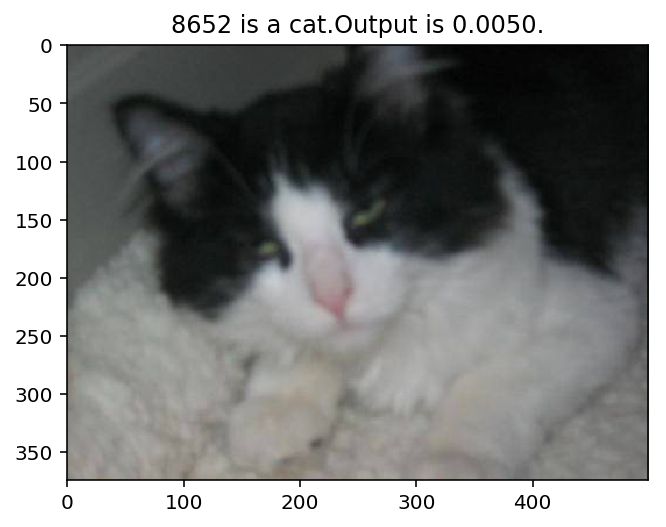

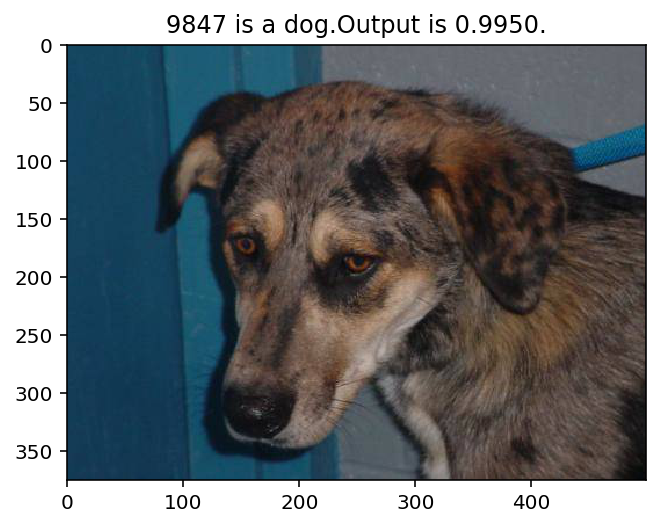

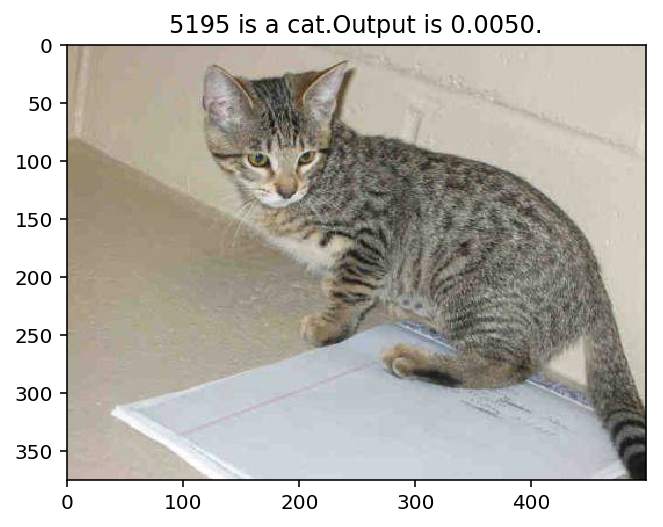

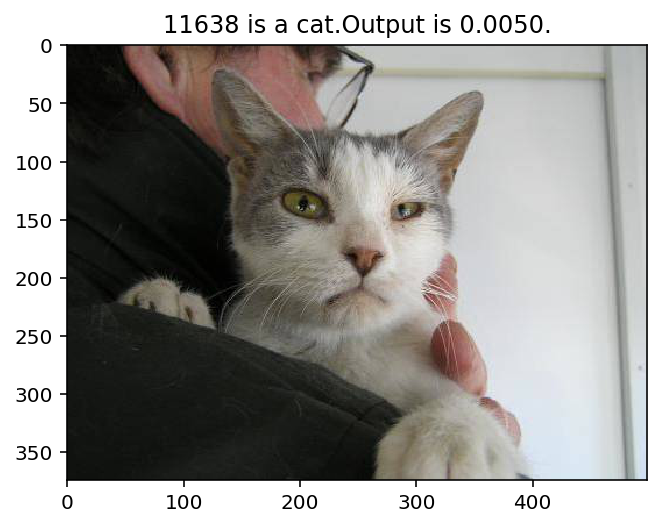

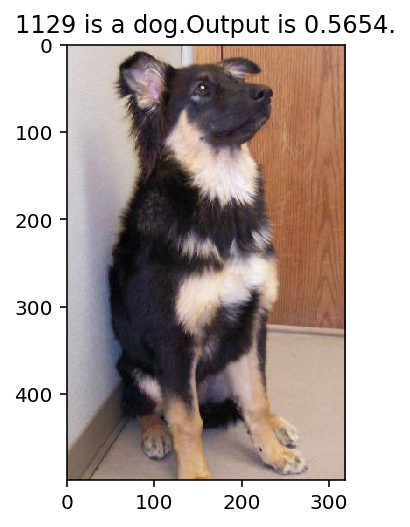

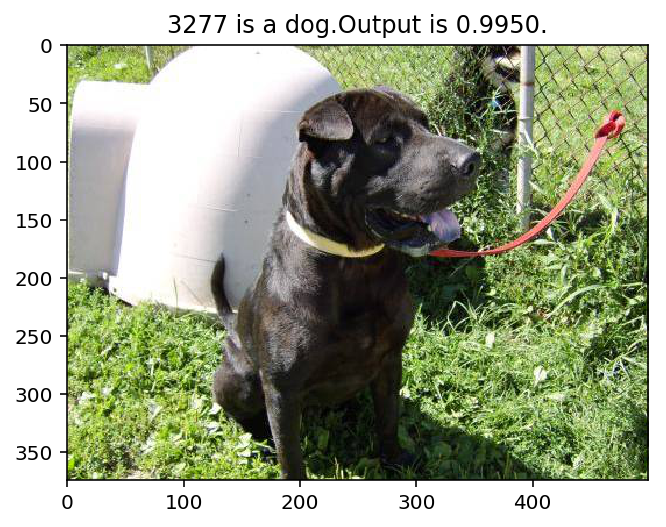

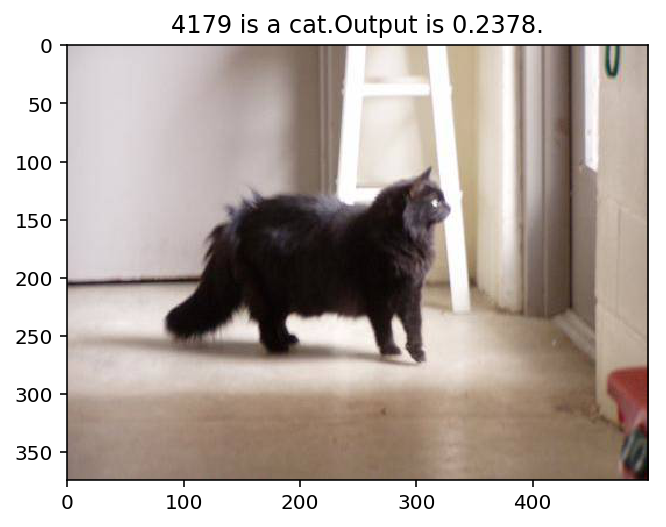

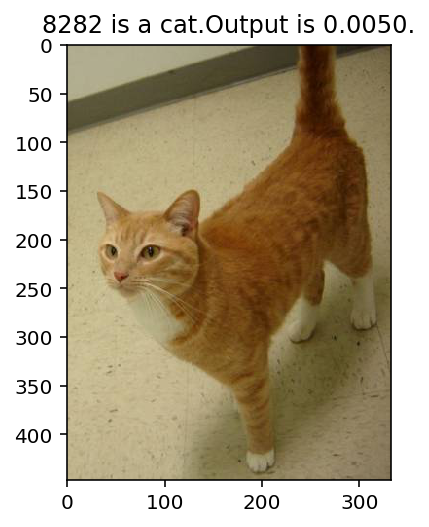

In [10]:
random_t(12)

In [11]:
df = pd.DataFrame({'accuracy':accuracy, 'loss_dict':loss_dict,'val_dict':val_dict})

In [12]:
df

accuracy  loss_dict  val_dict
1.120  0.9765625   0.096795  0.115463
1.160   0.953125   0.070630  0.073017
1.40   0.9921875   0.371920  0.197066
1.80   0.9921875   0.157885  0.109210
2.120  0.9765625   0.049680  0.051173
2.160   0.984375   0.043231  0.034557
2.40   0.9765625   0.050282  0.054120
2.80     0.96875   0.046511  0.052724
3.120  0.9921875   0.037122  0.025340
3.160  0.9765625   0.032608  0.069290
3.40    0.984375   0.042866  0.029075
3.80         1.0   0.036355  0.021364
4.120  0.9765625   0.032316  0.038466
4.160   0.984375   0.027878  0.025344
4.40         1.0   0.039539  0.016268
4.80         1.0   0.037182  0.013125
5.120        1.0   0.028935  0.010433
5.160        1.0   0.028141  0.012337
5.40         1.0   0.035385  0.010377
5.80    0.984375   0.031395  0.033722
6.120   0.984375   0.028012  0.048093
6.160        1.0   0.029017  0.017500
6.40    0.984375   0.033170  0.029797
6.80         1.0   0.030678  0.010552
7.120   0.984375   0.032192  0.101364
7.160  0.9921875   0.027094  0.037886
7.40    0.984375   0.023644  0.043269
7.80         1.0   0.025946  0.005490
8.120        1.0   0.027289  0.019248
8.160  0.9921875   0.027750  0.027684
8.40   0.9921875   0.025258  0.014666
8.80         1.0   0.026935  0.011321

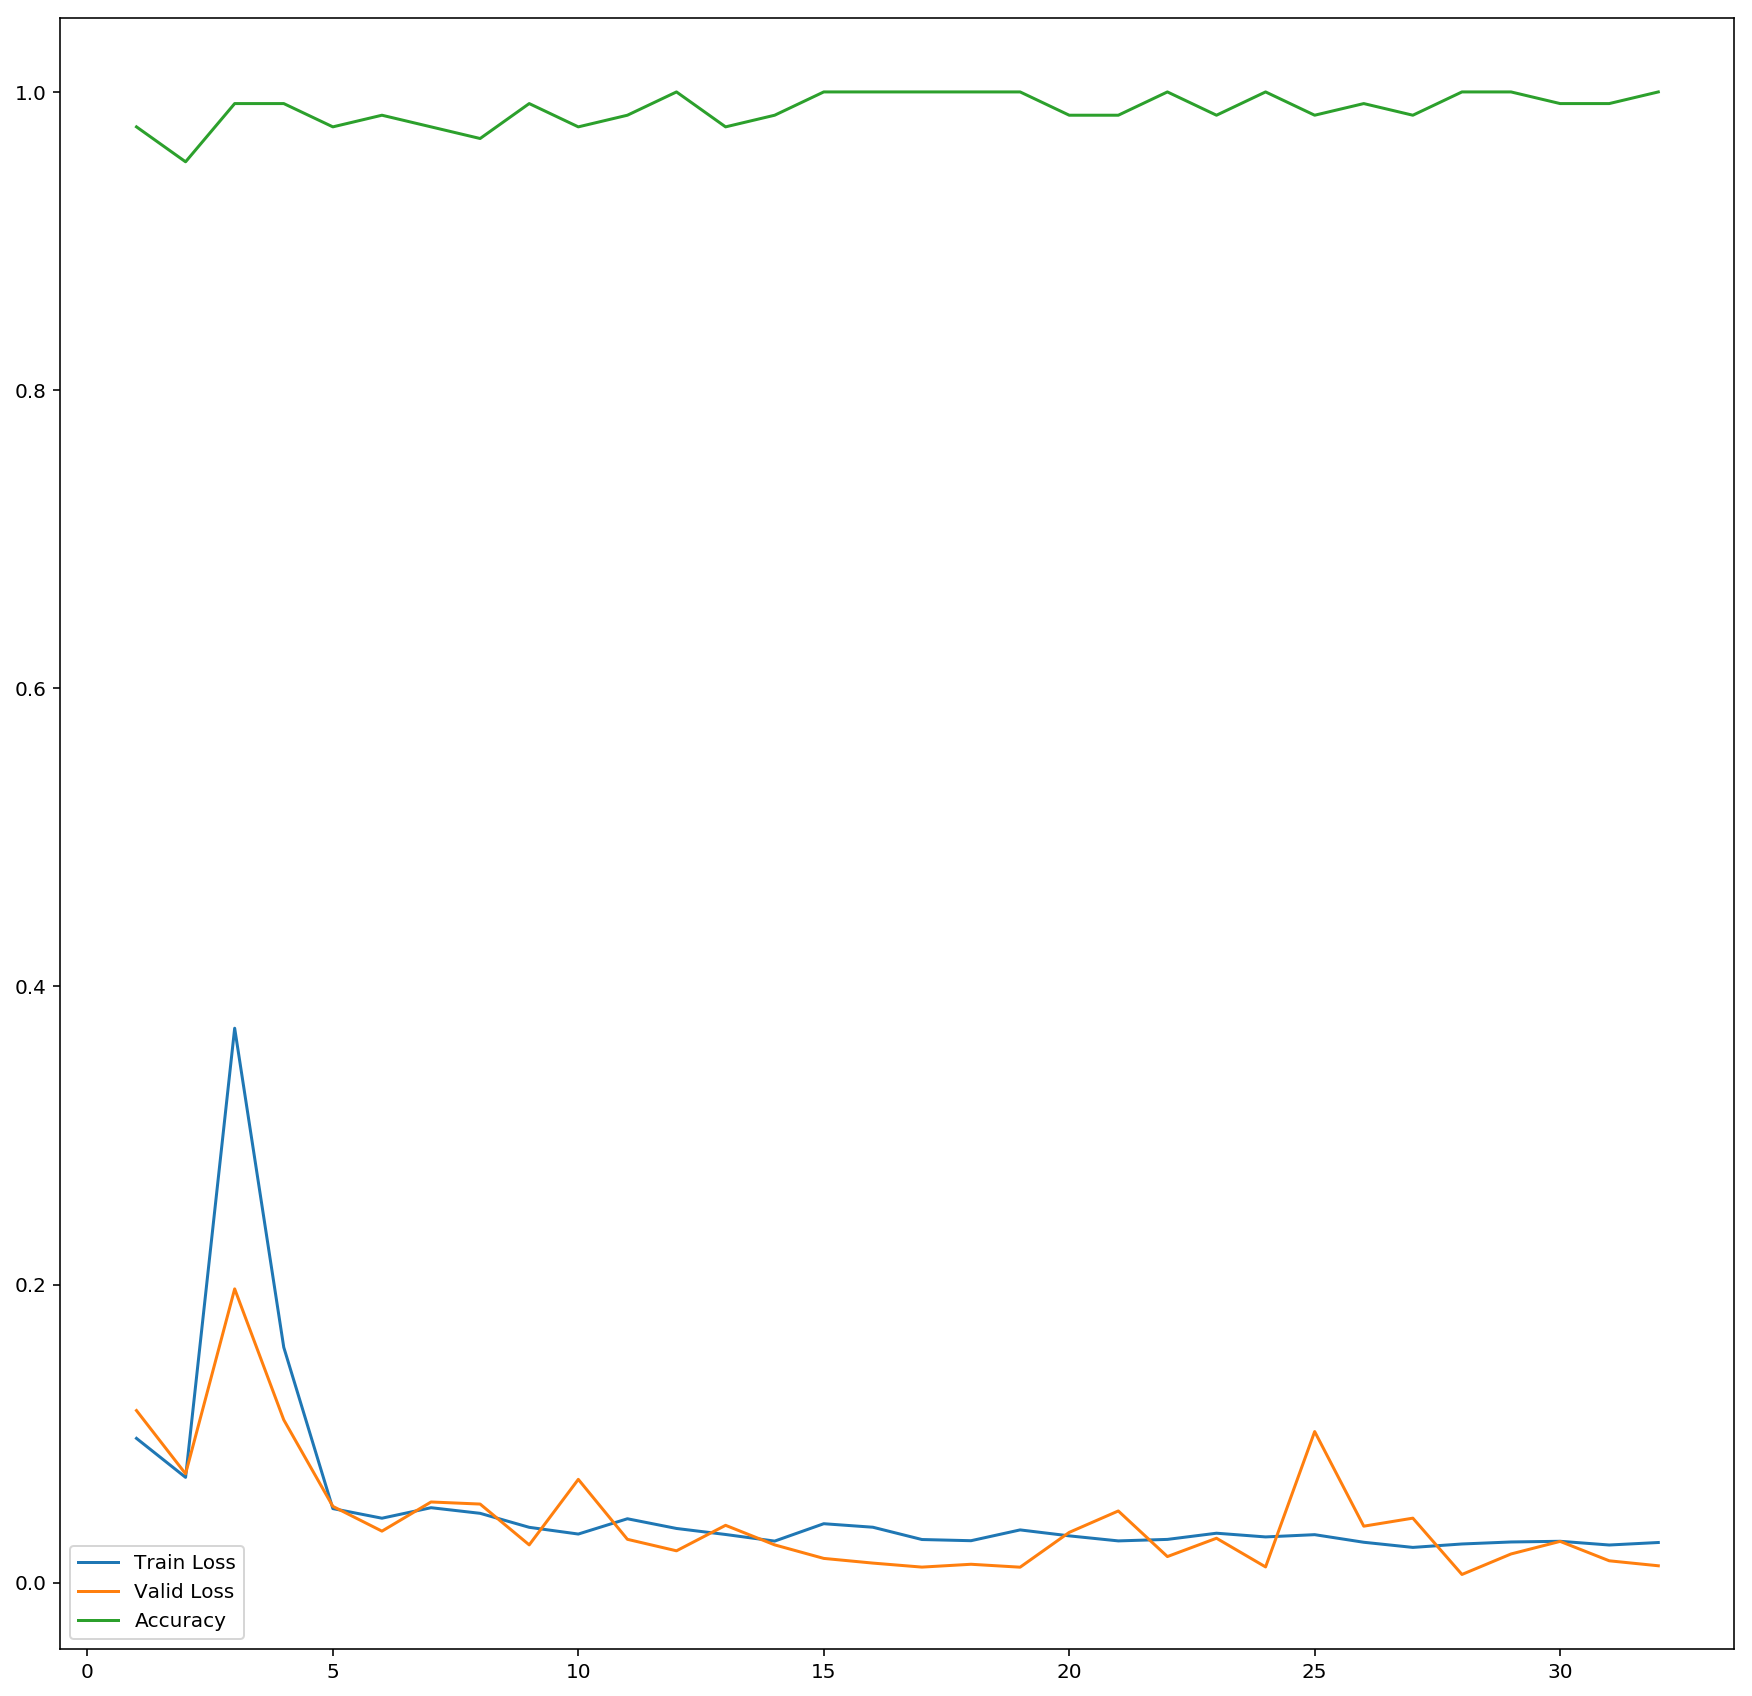

In [13]:
plt.figure(figsize=(15, 15))
x=np.arange(32) + 1
plt.plot(x,df['loss_dict'],label="Train Loss")
plt.plot(x,df['val_dict'],label="Valid Loss")
plt.plot(x,df['accuracy'], label='Accuracy')
plt.legend()
plt.show()